In [1]:
import numpy as np
import keras.backend as K
import tensorflow as tf

import Diffusion as df
import os.path
from autoencoder import *

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from keras.utils import np_utils
from keras.layers import Dense, Input
from keras.models import Model
from keras import regularizers

import scipy.ndimage

In [2]:
def im2patch(img, patch_dim=1):
    nrows, ncols = img.shape
    num_patches = (nrows - patch_dim + 1) * (ncols - patch_dim + 1)

    patches = np.zeros((patch_dim ** 2, num_patches))

    col_range = np.arange(ncols - patch_dim + 1)
    row_range = np.arange(nrows - patch_dim + 1)
    k = 0;
    for m in range(0, patch_dim):
        for n in range(0, patch_dim):
            col_inds = n + col_range
            row_inds = m + row_range
            patches[k, :] = np.reshape(img[row_inds,:][:,col_inds], (1, num_patches))
            k = k + 1
    
    return patches

In [8]:
patch_size = 5

data = plt.imread('bubble.png')
data=data.astype('float')/255.0

nrows, ncols = data.shape
# Show the image
plt.imshow(data,cmap='gray')
plt.show()

ValueError: too many values to unpack (expected 2)

Select 2k training patches out of ~40k patches

In [4]:
patches = im2patch(data, patch_size)
patches = patches.T
n_train = 2000
p = np.random.choice(patches.shape[0],n_train, replace=False)
patches_train = patches[p,:]

Calculate diffusion map of training patches

In [5]:
embedding_size = 3
k = 32
K_mat = df.ComputeLBAffinity(patches_train,k)   # Laplace-Beltrami affinity: D^-1 * K * D^-1
P     = df.makeRowStoch(K_mat)                     # markov matrix 
E1,v1 = df.Diffusion(K_mat, nEigenVals=embedding_size+1)  # eigenvalues and eigenvectors
embed_train = np.matmul(E1, np.diag(v1)) # diffusion maps

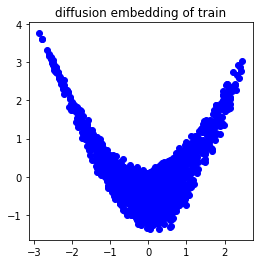

In [6]:
fig, (a1)  = plt.subplots(1,1)
a1.scatter(embed_train[:,0], embed_train[:,1],color='blue')
plt.title('diffusion embedding of train')
a1.set_aspect('equal')
plt.show()

Define network size 

In [7]:
input_size = patch_size**2
encoder_layer_sizes = [40, 20, embedding_size]
decoder_layer_sizes = [20, 40, input_size]
N_EPOCHS = 4000

## Encoder pre-training

In [8]:
ae1 = Autoencoder(input_size=input_size, hidden_size=encoder_layer_sizes[0], 
                            reg_par=1e-7,output_activation='linear')

ae1.compile(optimizer='adam')
ae1.train(patches_train,batch_size=n_train,n_epochs=N_EPOCHS)
ae1_out = ae1.predict(patches_train)

e1_out = ae1.encode(patches_train)

In [9]:
ae2 = Autoencoder(input_size=encoder_layer_sizes[0], hidden_size=encoder_layer_sizes[1], 
                            reg_par=1e-7,p=0.1,beta=0.01)

ae2.compile(optimizer='adam')
ae2.train(e1_out,batch_size=n_train,n_epochs=N_EPOCHS)

e2_out = ae2.encode(e1_out) # this is the output of the second hidden layer

In [10]:
reg3 = pretrain_regression(e2_out, embed_train, encoder_layer_sizes[1], encoder_layer_sizes[2], 
                               batch_size=n_train, reg_par=1e-7, n_epochs=N_EPOCHS) 

e3_out = reg3.predict(e2_out)

## Decoder pre-training

In [11]:
d_ae1 = Autoencoder(input_size=embedding_size, hidden_size=decoder_layer_sizes[0], 
                            reg_par=1e-4,output_activation='linear',p=0.05,beta=0.01)

d_ae1.compile(optimizer='adam')
d_ae1.train(embed_train,batch_size=n_train,n_epochs=N_EPOCHS)
de_output1 = d_ae1.predict(embed_train)

de1_out = d_ae1.encode(embed_train)  # this is the output of the first hidden layer

In [12]:
d_ae2 = Autoencoder(input_size=decoder_layer_sizes[0], hidden_size=decoder_layer_sizes[1], 
                            reg_par=1e-7,p=0.05,beta=0.01)                          

d_ae2.compile(optimizer='adam')
d_ae2.train(de1_out,batch_size=n_train,n_epochs=N_EPOCHS)
de2_out = d_ae2.encode(de1_out)

In [13]:
d_reg3 = pretrain_regression(de2_out, patches_train, decoder_layer_sizes[1], decoder_layer_sizes[2], 
                               batch_size=n_train, reg_par=1e-10, n_epochs=N_EPOCHS) 
de3_out = d_reg3.predict(de2_out)

## Train Diffusion Net

In [14]:
P  = tf.cast(tf.constant(P),tf.float32)
E1 = tf.cast(tf.constant(E1),tf.float32)
v1 = tf.cast(tf.constant(v1),tf.float32)

In [15]:
# the parameters for training the network
learning_rate = 1e-2
n_iters = 6000

X = tf.placeholder(tf.float32, shape=[None, input_size])
Y = tf.placeholder(tf.float32, shape=[None, embedding_size])

# params for loss function
reg_par = 1e-4
eta = 100


In [16]:
# create separate sessions for encoder and decoder to train so training encoder
# for various values of eta does not reset decoder every time
sess = tf.Session()
sessD = tf.Session()

In [17]:
# init diffusion net encoder units from pretrained autoencoders
init = tf.constant(ae1.get_weights()[0])
E_W1 = tf.Variable(init)
init = tf.constant(ae1.get_weights()[1])
E_b1 = tf.Variable(init)
init = tf.constant(ae2.get_weights()[0])
E_W2 = tf.Variable(init)
init = tf.constant(ae2.get_weights()[1])
E_b2 = tf.Variable(init)
init = tf.constant(reg3.layers[1].get_weights()[0])
E_W3 = tf.Variable(init)

theta_E = [E_W1,E_W2, E_W3, E_b1, E_b2]

def encoder(x):
    h1 = tf.nn. sigmoid(tf.matmul(x, E_W1) + E_b1)
    h2 = tf.nn.sigmoid(tf.matmul(h1, E_W2) + E_b2)
    h3 = tf.matmul(h2, E_W3)
    return h3

# set input and output placeholders
X = tf.placeholder(tf.float32, shape=[None, input_size])
Z = encoder(X)

# set encoder loss
encoder_fidelity_loss = tf.reduce_mean(tf.square(Y-Z))
encoder_eigen_loss = 0
for i in range(embedding_size):
    mat = P - v1[i]*np.eye(n_train,dtype=np.float32)
    z_vec =  tf.slice(Z,[0,i],[-1,1])
    vec = tf.matmul(mat, z_vec)
    encoder_eigen_loss += tf.reduce_mean(tf.square(vec))
encoder_reg = tf.nn.l2_loss(E_W3) #+tf.nn.l2_loss(E_W1) + tf.nn.l2_loss(E_W2)

encoder_loss = encoder_fidelity_loss + eta*encoder_eigen_loss + reg_par*encoder_reg

In [18]:
E_solver = (tf.train.AdamOptimizer(learning_rate=learning_rate)
            .minimize(encoder_loss, var_list=theta_E))

sess.run(tf.global_variables_initializer())

In [19]:
# train encoder
z = sess.run(Z, feed_dict={X: patches_train})
loss = np.mean(np.sum(np.abs(embed_train - z)**2,axis=1)**(1./2))
print('Initial encoder loss %.2e' % (loss))

for iter in range(n_iters+1):
    _ = sess.run(E_solver, feed_dict={X: patches_train, Y:embed_train})

z = sess.run(Z, feed_dict={X: patches_train})
loss = np.mean(np.sum(np.abs(embed_train - z)**2,axis=1)**(1./2))
print('Final encoder loss %.2e' % (loss))

Initial encoder loss 2.00e+00
Final encoder loss 5.85e-01


In [20]:
# init diffusion net decoder units from pretrained autoencoders
init = tf.constant(d_ae1.get_weights()[0])
D_W1 = tf.Variable(init)
init = tf.constant(d_ae1.get_weights()[1])
D_b1 = tf.Variable(init)
init = tf.constant(d_ae2.get_weights()[0])
D_W2 = tf.Variable(init)
init = tf.constant(d_ae2.get_weights()[1])
D_b2 = tf.Variable(init)
init = tf.constant(d_reg3.layers[1].get_weights()[0])
D_W3 = tf.Variable(init)

theta_D = [D_W1, D_W2, D_W3, D_b1, D_b2]

def decoder(z):
    h1 = tf.nn.sigmoid(tf.matmul(z, D_W1) + D_b1)
    h2 = tf.nn.sigmoid(tf.matmul(h1, D_W2) + D_b2)
    h3 = tf.matmul(h2, D_W3)
    return h3

# set input and output placeholders
Y = tf.placeholder(tf.float32, shape=[None, embedding_size])
R = decoder(Y)

# set decoder loss
decoder_reg = tf.nn.l2_loss(D_W3) #+tf.nn.l2_loss(D_W1) + tf.nn.l2_loss(D_W2)
decoder_loss = tf.reduce_mean(tf.square(X-R)) + reg_par*decoder_reg


In [21]:
D_solver = (tf.train.AdamOptimizer(learning_rate=learning_rate)
            .minimize(decoder_loss, var_list=theta_D))

sessD.run(tf.global_variables_initializer())


In [22]:
# train decoder
r = sessD.run(R, feed_dict={Y:embed_train})

loss = np.mean(np.sum(np.abs(patches_train - r)**2,axis=1)**(1./2))
print('Initial decoder loss %.2e' % (loss))
for iter in range(n_iters):
    _ = sessD.run(D_solver, feed_dict={X: patches_train, Y:embed_train})

r = sessD.run(R, feed_dict={Y:embed_train})

loss = np.mean(np.sum(np.abs(patches_train - r)**2,axis=1)**(1./2))
print('Decoder loss %.2e' % (loss))

Initial decoder loss 7.22e-01
Decoder loss 3.65e-01


Stack encoder and decoder

Auto-encode for all patches

Reconstruction error of every patch relative to avergae reconstruction error of the training patches is the anomaly measure

In [23]:
r_train = sessD.run(R, feed_dict={Y:z})
loss = (np.sum(np.abs(patches_train - r_train)**2,axis=1)**(1./2))
mean_train_loss = np.mean(loss)
print('Diffusion net mean training error %.2e' % (mean_train_loss))

Diffusion net mean training error 4.66e-01


In [24]:
z_all = sess.run(Z, feed_dict={X: patches})
r_all = sessD.run(R, feed_dict={Y:z_all})
loss = (np.sum(np.abs(patches - r_all)**2,axis=1)**(1./2))
mean_loss = np.mean(loss)
print('Diffusion net mean error %.2e' % (mean_loss))

Diffusion net mean error 4.73e-01


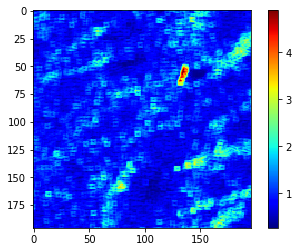

In [25]:
loss = loss / mean_train_loss
plt.imshow(loss.reshape(nrows-patch_size+1, ncols-patch_size+1),cmap='jet')
plt.colorbar()
plt.show()